# Anomaly Detection

<a href="https://colab.research.google.com/github/andrewm4894/netdata-community/blob/netdata-pandas-example/netdata-agent-api/netdata-pandas/anomaly_detection.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will use the [netdata-pandas](https://github.com/netdata/netdata-pandas) Python package to pull some recent data from a demo Netdata server and run some anomaly detection algorithims from the [ADTK](https://adtk.readthedocs.io/en/stable/) package. 

**Note**: you can click the "Open in Colab" button above to open this notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) where you can just get going with it without having to set up python enviornments or any messy stuff like that.

In [6]:
# if you need to, uncomment below to install netdata-pandas and adtk packages
#!pip install netdata-pandas==0.0.27 adtk==0.6.2

In [7]:
import random
import numpy as np
import pandas as pd
from adtk.detector import (
    QuantileAD, InterQuartileRangeAD, PcaAD, PersistAD, LevelShiftAD, VolatilityShiftAD, OutlierDetector, 
    RegressionAD, MinClusterDetector, AutoregressionAD, SeasonalAD)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from adtk.visualization import plot
from netdata_pandas.data import get_data


def init_model(model, metric=None):
    if model == 'quantile':
        detector = QuantileAD()
    elif model == 'iqr':
        detector = InterQuartileRangeAD()
    elif model == 'pca':
        detector = PcaAD()
    elif model == 'persist':
        detector = PersistAD()
    elif model == 'level':
        detector = LevelShiftAD(c=6.0, side='both', window=5)
    elif model == 'volatility':
        detector = VolatilityShiftAD(c=6.0, side='both', window=30)
    elif model == 'lof':
        detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
    elif model == 'regression':
        detector = RegressionAD(regressor=LinearRegression(), target=metric, c=3.0)
    elif model == 'kmeans':
        detector = MinClusterDetector(KMeans(n_clusters=2))
    elif model == 'ar':
        detector = AutoregressionAD(n_steps=7*2, step_size=24, c=3.0)
    elif model == 'seasonal':
        detector = SeasonalAD(c=3.0, side="both")
    else:
        detector = PcaAD()
    return detector


Lets pull the data from three demo nodes for a subset of charts for the last 15 minutes.

In [8]:
# inputs
host = [random.choice(['london.my-netdata.io', 'newyork.my-netdata.io', 'cdn77.my-netdata.io', 'octopuscs.my-netdata.io'])]
charts = ['system.cpu', 'system.load', 'system.io', 'system.ram', 'system.net', 'system.ip', 'system.processes', 'system.intr', 'system.softnet_stat']
model = 'ar'
before = 0
after = -60*60 # lets look at last 60 minutes
diff = False # True to take differences before doing anomaly detection

In [9]:
# get the data
print(host)
df = get_data(hosts=host, charts=charts, after=after, before=before, index_as_datetime=True, nunique_thold=0.05)
print(df.shape)
df.head()

['cdn77.my-netdata.io']
(3601, 15)


system.cpu|iowait  system.cpu|nice  system.cpu|system  \
time_idx                                                                     
2020-10-23 14:13:50                NaN              NaN                NaN   
2020-10-23 14:13:52           0.000000              0.0           2.525253   
2020-10-23 14:13:53          26.395940              0.0           1.522843   
2020-10-23 14:13:54          10.659898              0.0           1.015228   
2020-10-23 14:13:55           0.000000              0.0           1.015228   

                     system.intr|interrupts  system.io|out  \
time_idx                                                     
2020-10-23 14:13:50                     NaN            NaN   
2020-10-23 14:13:52                464.3740         0.0000   
2020-10-23 14:13:53                487.6165     -1894.6590   
2020-10-23 14:13:54                395.5229     -1625.3414   
2020-10-23 14:13:55                372.9420         0.0000   

                     system.ip|received  system.ip|sent  system.load|load1  \
time_idx                                                                     
2020-10-23 14:13:50                 NaN             NaN           0.868181   
2020-10-23 14:13:52            76.55302       -73.85556           0.868181   
2020-10-23 14:13:53            71.20174       -74.58908           0.868181   
2020-10-23 14:13:54           180.00500      -260.74190           0.868181   
2020-10-23 14:13:55           261.05580      -413.46370           0.950000   

                     system.net|received  system.net|sent  system.ram|buffers  \
time_idx                                                                        
2020-10-23 14:13:50                  NaN              NaN                 NaN   
2020-10-23 14:13:52             54.87692        -41.31522            245.6055   
2020-10-23 14:13:53             51.03319        -42.51146            245.6094   
2020-10-23 14:13:54             64.53976       -132.48705            245.6094   
2020-10-23 14:13:55             66.17816       -206.34250            245.6094   

                     system.ram|cached  system.ram|free  system.ram|used  \
time_idx                                                                   
2020-10-23 14:13:50                NaN              NaN              NaN   
2020-10-23 14:13:52            2657.07         381.0117         681.7617   
2020-10-23 14:13:53            2657.07         381.0664         681.7031   
2020-10-23 14:13:54            2657.07         381.1406         681.6289   
2020-10-23 14:13:55            2657.07         380.8906         681.8789   

                     system.softnet_stat|processed  
time_idx                                            
2020-10-23 14:13:50                            NaN  
2020-10-23 14:13:52                       178.6010  
2020-10-23 14:13:53                       178.1433  
2020-10-23 14:13:54                       198.4958  
2020-10-23 14:13:55                       192.6708

## Anomaly Detection!

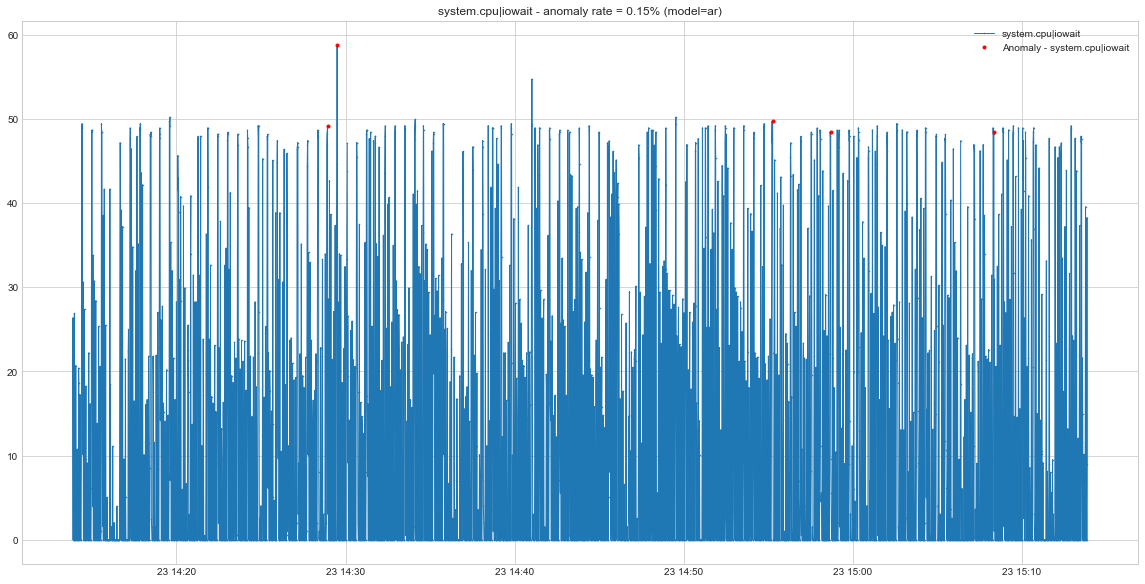

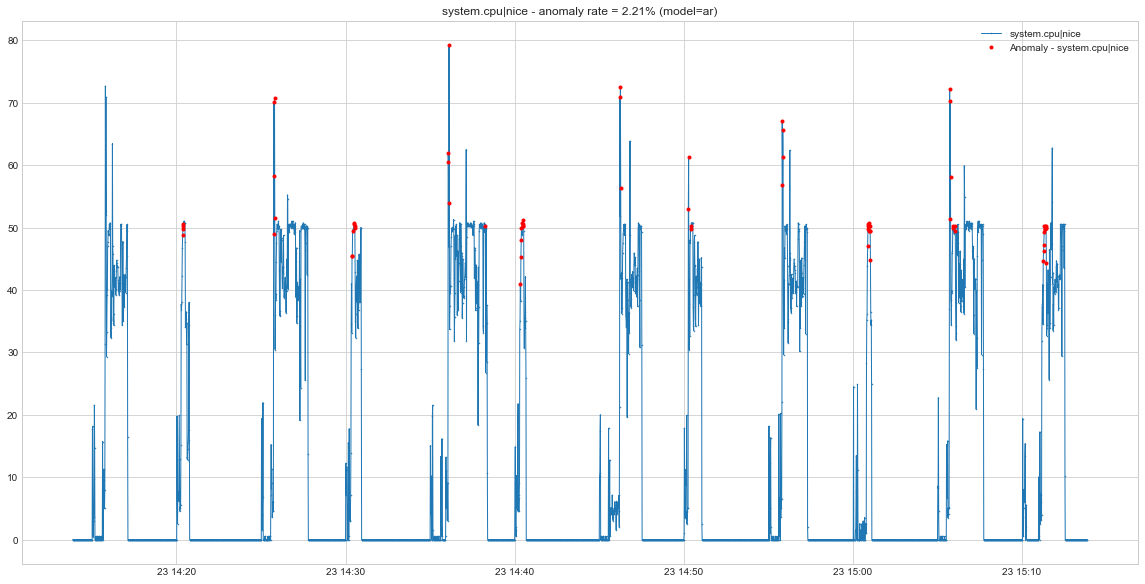

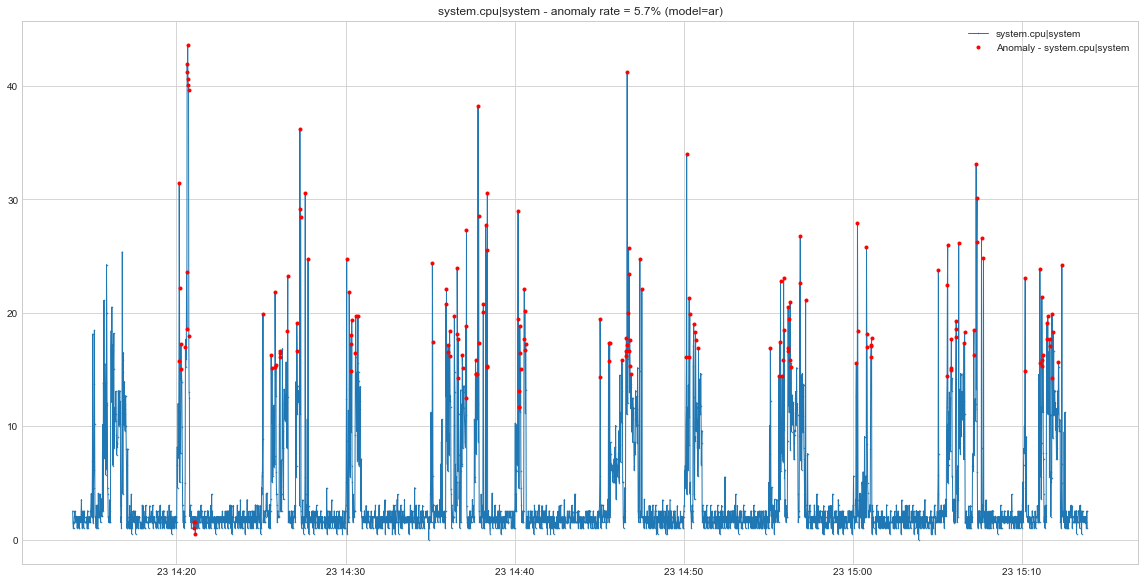

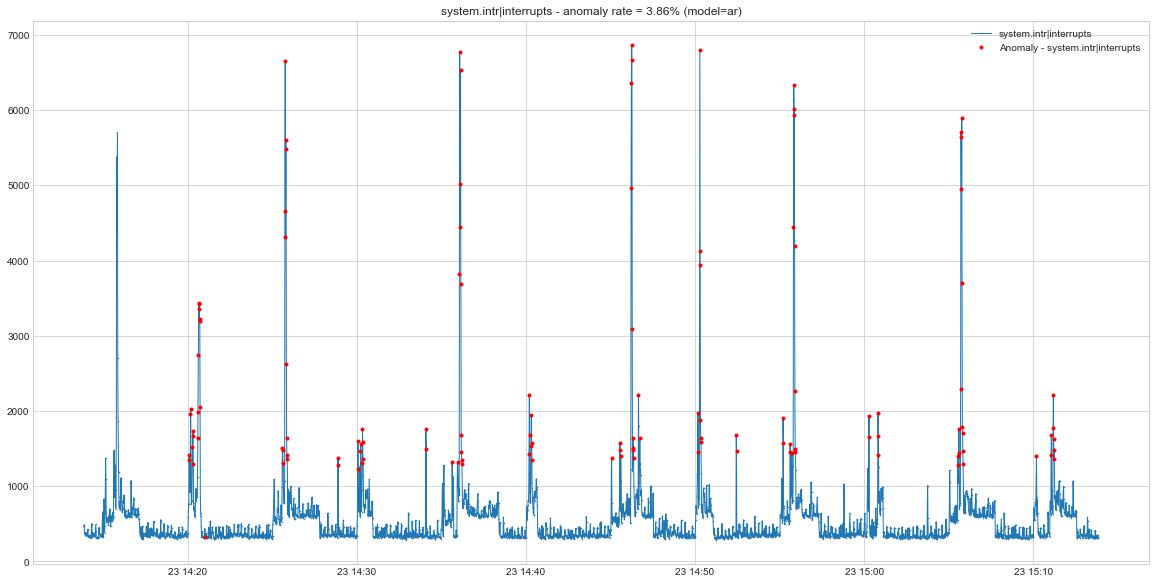

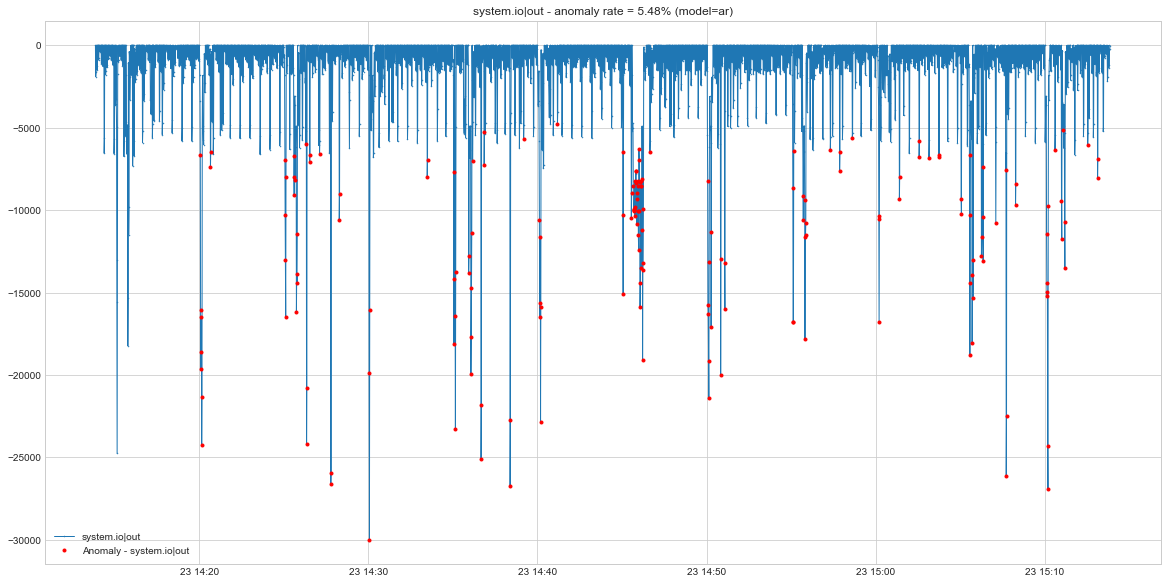

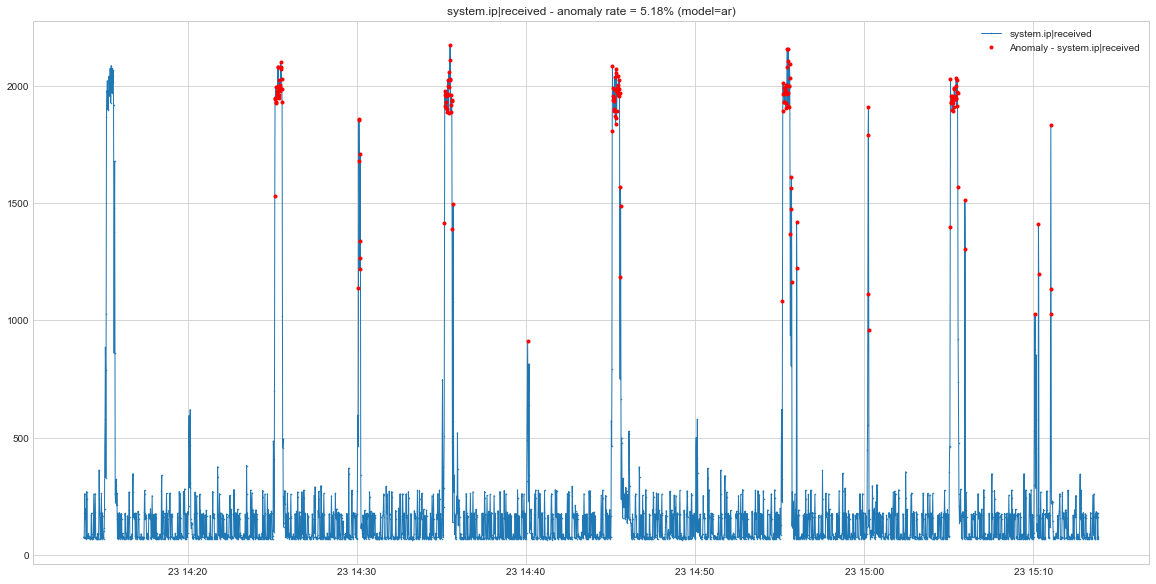

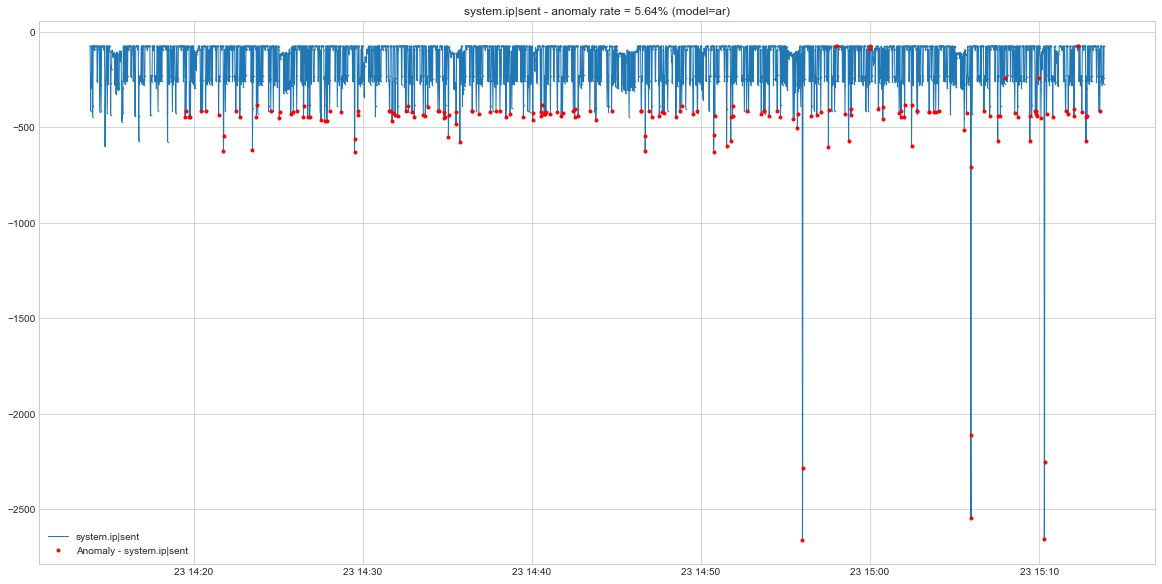

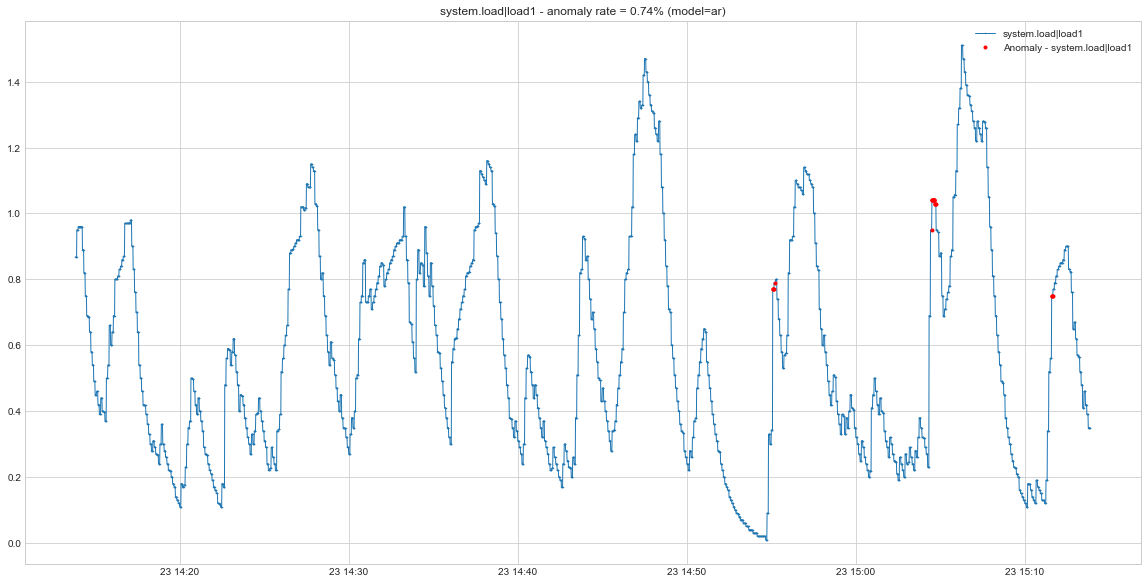

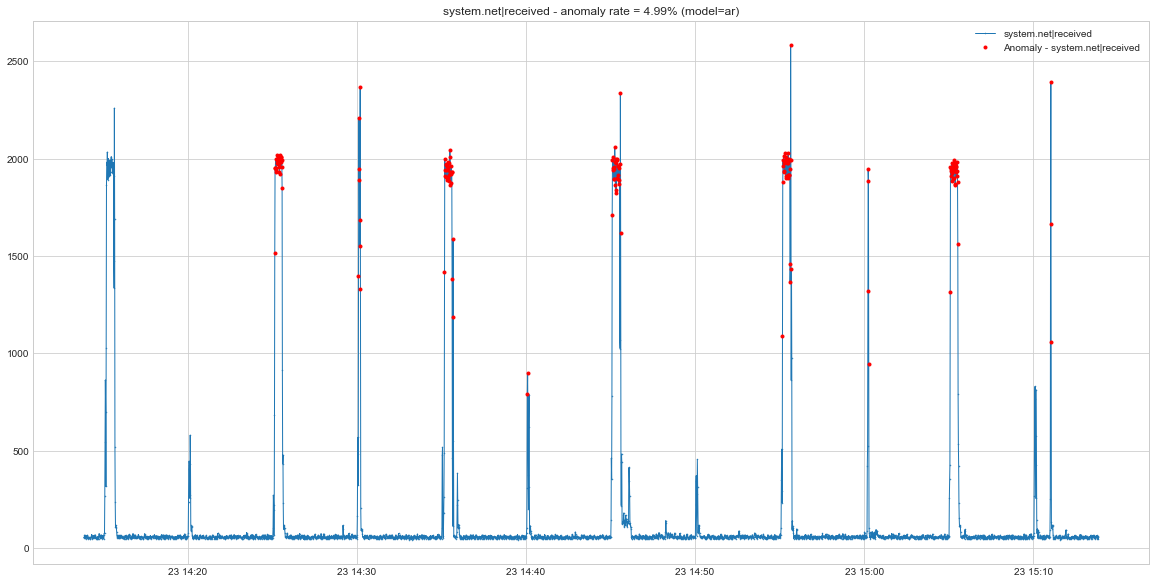

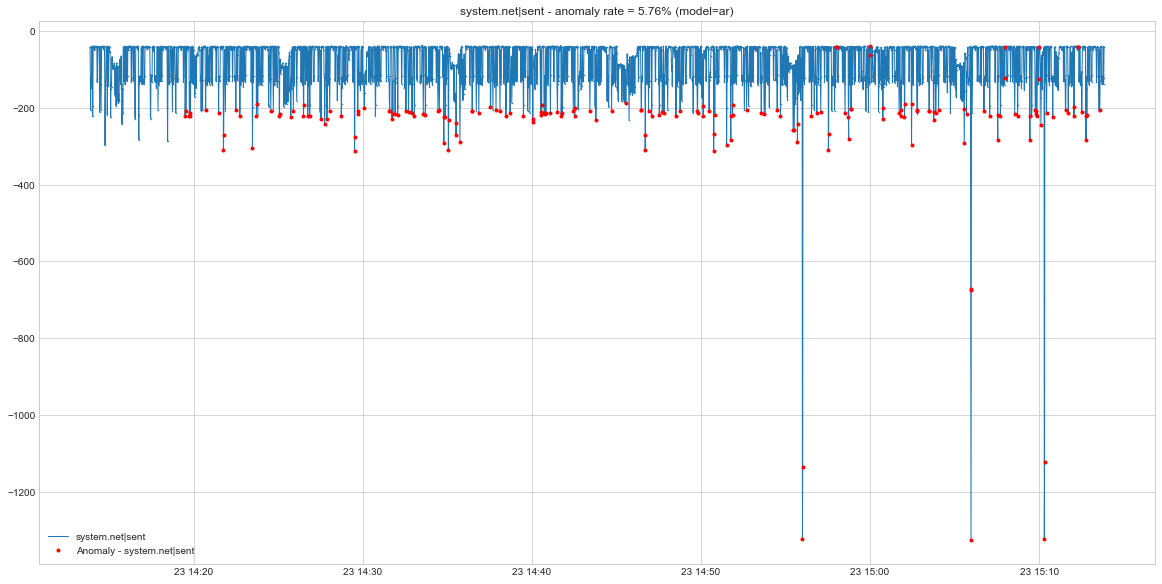

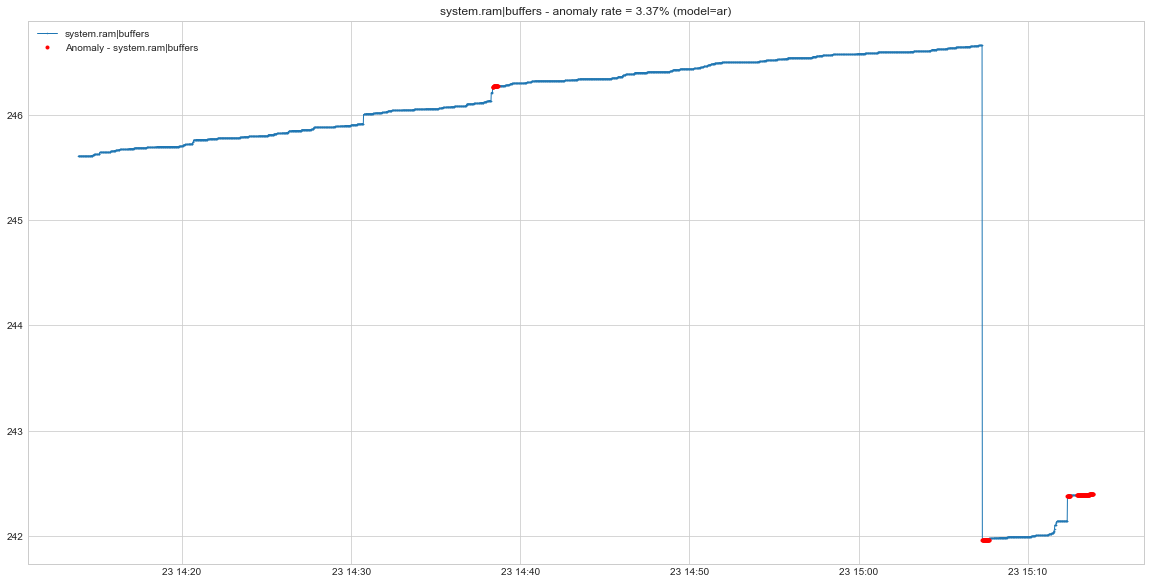

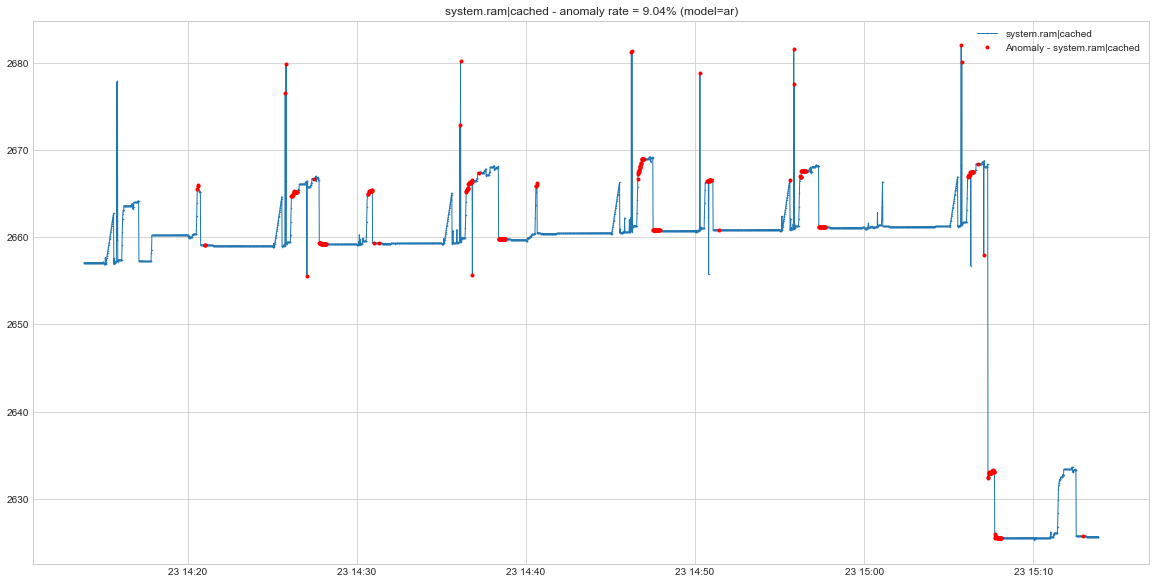

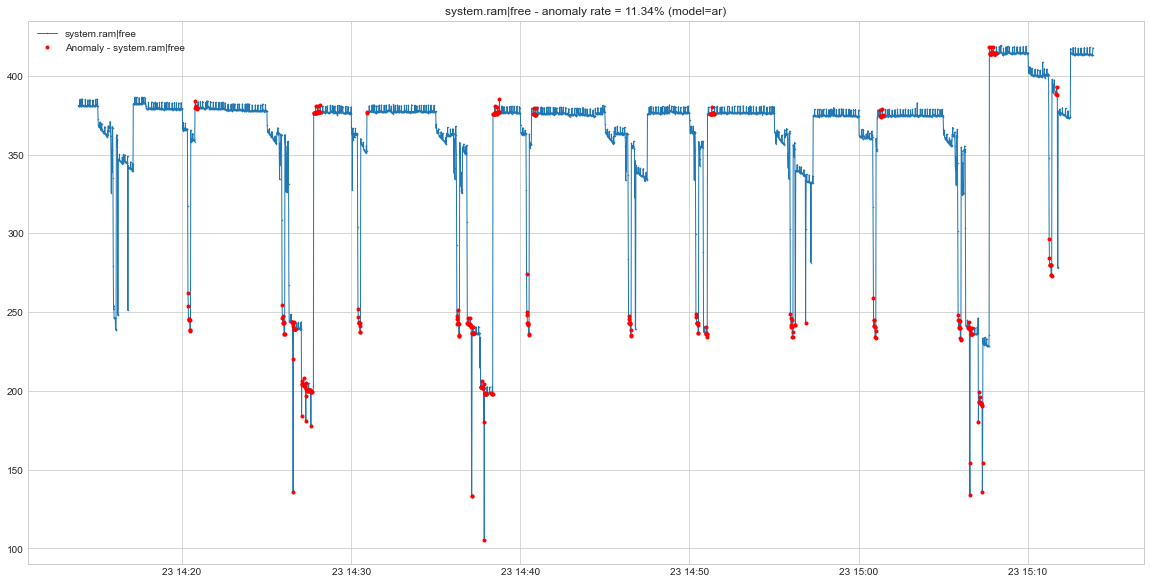

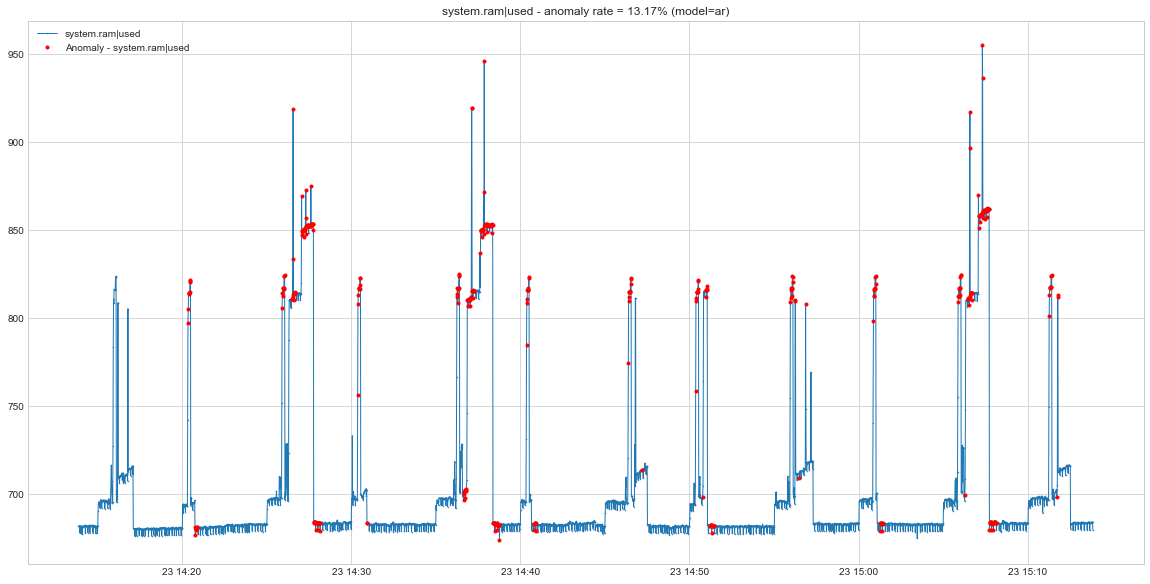

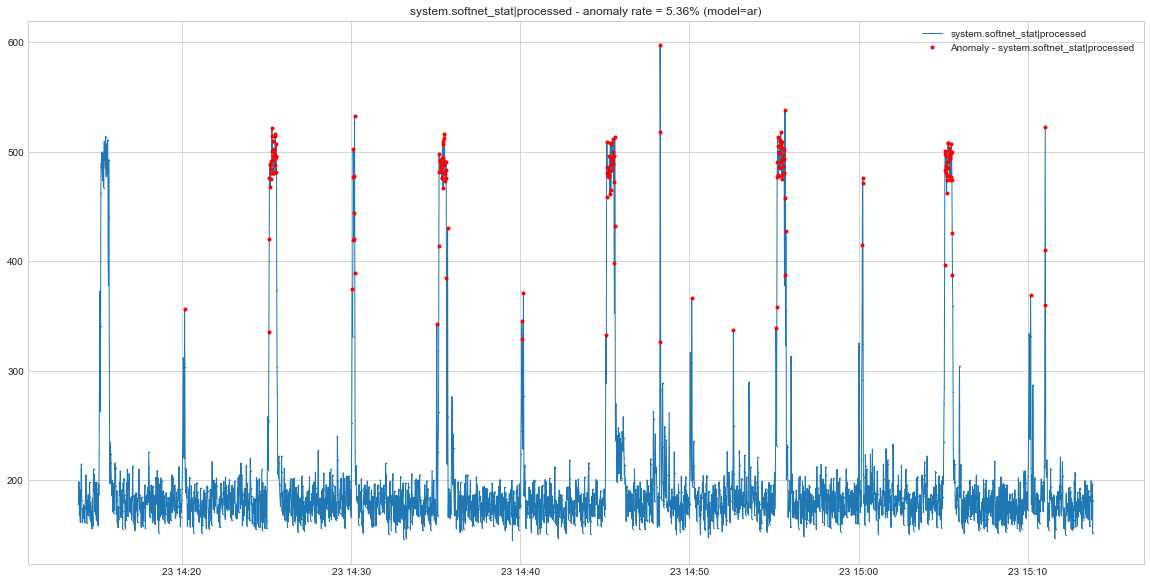

In [10]:
# lets do anomaly detection for each metric
metrics_in_scope = df.columns

# loop over each metric and run detector
for metric in metrics_in_scope:
    detector = init_model(model, metric)
    try:
        if diff:
            X = df[[metric]].diff(1)
        else:
            X = df[[metric]]
        # look for anomalies
        anomalies = detector.fit_detect(X)
        num_obs = len(anomalies.dropna())
        num_anomalies = anomalies.dropna().values.sum()
        anomaly_rate = round(100 * (num_anomalies/num_obs), 2) 
        # plot anomalies found
        ax = plot(
            X, anomaly=anomalies, ts_linewidth=1, ts_markersize=1, anomaly_markersize=3, 
            anomaly_color='red', anomaly_tag="marker", figsize=(20,10))
        ax[0].set_title(f'{metric} - anomaly rate = {anomaly_rate}% (model={model})')
    except Exception as e:
        print(e)
        print(f'... fit_detect failed for model={model}, metric={metric}')
